In [1]:
# import ee
# # authentication
# service_account = ...
# credentials = ee.ServiceAccountCredentials(service_account, ...)
# ee.Initialize(credentials)

In [2]:
import folium
import geemap
import os
import IPython.display as disp
from IPython.display import Image
import glob

In [3]:
# !pip install rasterio
import rasterio #for reading images

In [4]:
from sklearn import cluster
from sklearn.metrics import silhouette_score
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt 

In [6]:
import sys

sys.path.append('../src/data/')
sys.path.append('../src/features/')
sys.path.append('../src/models/')
sys.path.append('../src/visualization/')
import make_dataset

Use this website to generate new JSON structures: https://geojson.io/#new&map=10.57/39.6198/-121.4357

In [7]:
# might be useful later
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -121.57931418110947,
              39.73107014130147
            ],
            [
              -121.57931418110947,
              39.524185236048766
            ],
            [
              -121.28277910072802,
              39.524185236048766
            ],
            [
              -121.28277910072802,
              39.73107014130147
            ],
            [
              -121.57931418110947,
              39.73107014130147
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [8]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

start_date = '2013-03-18'
end_date = '2022-10-24'

In [9]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

Used some code from here: https://gis.stackexchange.com/questions/332259/calculate-ndwi-of-each-image-in-a-imagecollection

In [43]:
# import Landsat 8 Level 2, Collection 2, Tier 1 surface reflectance
images_sr = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterDate(start_date, end_date).filterBounds(aoi)

In [44]:
# filter cloudy images, threshold of 50%
images_sr = images_sr.filter(ee.Filter.lte('CLOUD_COVER', 0.50))

### Export Image Collection Section

In [45]:
# SR_B3 band
sr_b3 = images_sr.select('SR_B3')
collection_list = sr_b3.toList(sr_b3.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(sr_b3, date_format='YYYY-MM-dd').getInfo()

In [47]:
# exportData(
#     dates, 
#     collection_size, 
#     collection_list, 
#     "./Data/images/LANDSAT8/LANDSAT8_SR_B3/LANDSAT8_SR_B3_{}.tif"
# )

In [ ]:
# SR_B5 band
sr_b5 = images_sr.select('SR_B5')
collection_list = sr_b5.toList(sr_b5.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(sr_b5, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# exportData(
#     dates, 
#     collection_size, 
#     collection_list, 
#     "./Data/images/LANDSAT8/LANDSAT8_SR_B5/LANDSAT8_SR_B5_{}.tif"
# )

In [ ]:
# ndwi band
ndwi_images = images_sr.map(computeNDWI).select("NDWI")
collection_list = ndwi_images.toList(ndwi_images.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(ndwi_images, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# exportData(
#     dates, 
#     collection_size, 
#     collection_list, 
#     "./Data/images/LANDSAT8/LANDSAT8_SR_NDWI/LANDSAT8_{}.tif"
# )

In [ ]:
# mndwi band
mndwi_images = images_sr.map(computeMNDWI).select("MNDWI")
collection_list = mndwi_images.toList(mndwi_images.size())
collection_size = collection_list.size().getInfo()
# has a bug, has many dates that shouldnt be there. However, I will fix later
dates = geemap.image_dates(mndwi_images, date_format='YYYY-MM-dd').getInfo()

In [ ]:
# exportData(
#     dates, 
#     collection_size, 
#     collection_list, 
#     "./Data/images/LANDSAT8/LANDSAT8_SR_MNDWI/LANDSAT8_{}.tif"
# )

### Read Data Section
Make a list of all gathered images in the form of (date, image) tuples.

In [ ]:
#mndwi_img_lst = readData("./Data/images/LANDSAT8/LANDSAT8_SR_MNDWI/")

In [12]:
# provide path to images
ndwi_img_lst = make_dataset.readData("../data/images/LANDSAT8/LANDSAT8_SR_NDWI/")

In [13]:
print(ndwi_img_lst[0][0])
print(ndwi_img_lst[0][1].shape)

2013-06-03
(781, 863)


In [14]:
b3_img_lst = make_dataset.readData("../data/images/LANDSAT8/LANDSAT8_SR_B3/")

In [15]:
print(b3_img_lst[0][0])
print(b3_img_lst[0][1].shape)

2013-06-03
(781, 863)


In [16]:
b5_img_lst = make_dataset.readData("../data/images/LANDSAT8/LANDSAT8_SR_B5/")

In [18]:
# Doesnt work too well at the moment 
computed_ndwi_lst = make_dataset.computeNDWI(b3_img_lst, b5_img_lst)

NameError: name 'b3_img_lst' is not defined

Apply spatial median filtering in an effort to reduce cloud noise

In [100]:
spatial_median_img_lst = []

for i in range(1, len(ndwi_img_lst) - 1):
    
    img1 = ndwi_img_lst[i-1][1]
    img2 = ndwi_img_lst[i][1]
    img3 = ndwi_img_lst[i+1][1]
    
    median_img = np.median(
        np.dstack([img1,img2,img3]), 
        -1
    )
    spatial_median_img_lst.append((
        "{}::{}::{}".format(ndwi_img_lst[i-1][0],ndwi_img_lst[i][0],ndwi_img_lst[i+1][0]),
        median_img
    ))

### Data Viz Section

2013-06-03


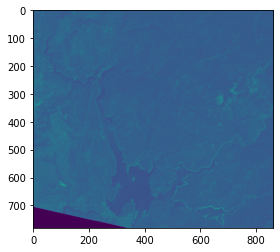

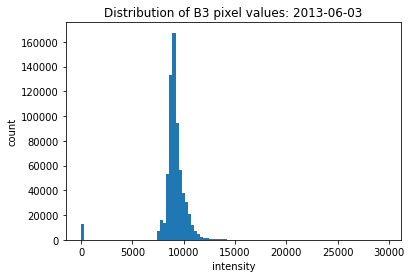

In [19]:
print(b3_img_lst[0][0])
plt.imshow(b3_img_lst[0][1])
plt.show()

plt.hist(
    b3_img_lst[0][1].flatten(), 
    bins=100
)
plt.ylabel("count")
plt.xlabel("intensity")
plt.title("Distribution of B3 pixel values: {}".format(b3_img_lst[0][0]))
plt.show()

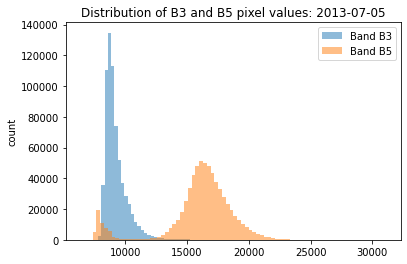

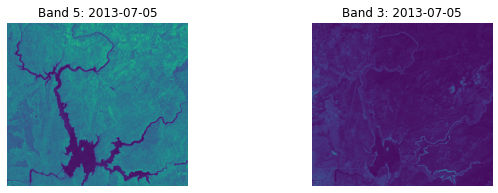

In [106]:
plt.hist(
    b3_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b5_img_lst[1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B5"
)
plt.legend()
plt.ylabel("count")
plt.title("Distribution of B3 and B5 pixel values: {}".format(b5_img_lst[1][0]))
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b5_img_lst[1][1])
ax[0].set_title('Band 5: {}'.format(b5_img_lst[1][0]))

ax[1].imshow(b3_img_lst[1][1])
ax[1].set_title('Band 3: {}'.format(b3_img_lst[1][0]))


for a in ax:
    a.axis('off')

plt.show()

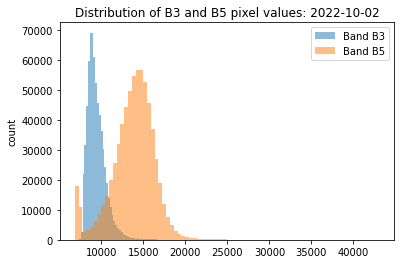

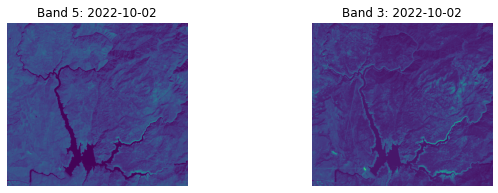

In [109]:
plt.hist(
    b3_img_lst[-1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b5_img_lst[-1][1].flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B5"
)

plt.legend()
plt.ylabel("count")
plt.title("Distribution of B3 and B5 pixel values: {}".format(b5_img_lst[-1][0]))
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b5_img_lst[-1][1])
ax[0].set_title('Band 5: {}'.format(b5_img_lst[-1][0]))

ax[1].imshow(b3_img_lst[-1][1])
ax[1].set_title('Band 3: {}'.format(b3_img_lst[-1][0]))


for a in ax:
    a.axis('off')

plt.show()

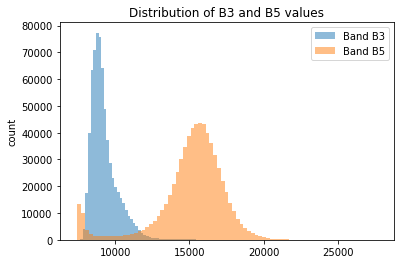

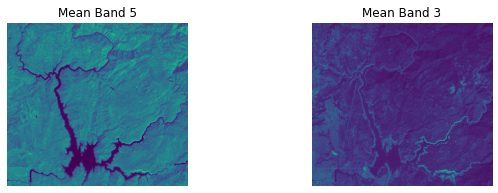

In [95]:
b3_mean_per_pixel = []
b5_mean_per_pixel = []
for i in range(1, len(b3_img_lst)):
    b3_mean_per_pixel.append(b3_img_lst[i][1])
    b5_mean_per_pixel.append(b5_img_lst[i][1])

b3_mean_per_pixel  = np.mean(
        np.dstack(b3_mean_per_pixel), 
        -1
    )
b5_mean_per_pixel  = np.mean(
        np.dstack(b5_mean_per_pixel), 
        -1
    )

plt.hist(
    b3_mean_per_pixel.flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B3"
)
plt.hist(
    b5_mean_per_pixel.flatten(), 
    bins=80,
    alpha=0.5,
    label="Band B5"
)
plt.title("Distribution of B3 and B5 values")
plt.legend()
plt.ylabel("count")
plt.show()


fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()

ax[0].imshow(b5_mean_per_pixel)
ax[0].set_title('Mean Band 5')

ax[1].imshow(b3_mean_per_pixel)
ax[1].set_title('Mean Band 3')


for a in ax:
    a.axis('off')

plt.show()

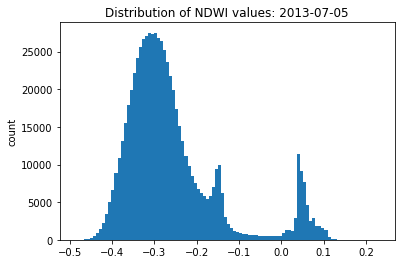

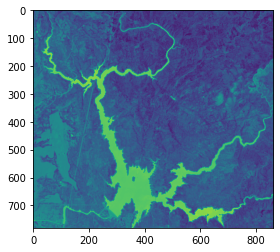

In [94]:
den = (b3_img_lst[1][1] + b5_img_lst[1][1]).astype(np.int)
num = (np.subtract(b3_img_lst[1][1].astype(np.int), b5_img_lst[1][1].astype(np.int)))
ndwi_img = num / den
plt.hist(ndwi_img.flatten(),bins=100)
plt.title("Distribution of NDWI values: {}".format(b3_img_lst[1][0]))
plt.ylabel("count")
plt.show()

plt.imshow(ndwi_img)
plt.show()

2013-06-03::2013-07-05::2013-07-21


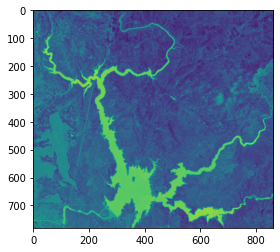

In [101]:
print(spatial_median_img_lst[0][0])
plt.imshow(spatial_median_img_lst[0][1])
plt.show()

2022-08-31::2022-09-16::2022-10-02


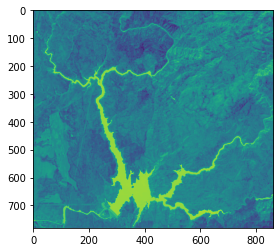

In [102]:
print(spatial_median_img_lst[-1][0])
plt.imshow(spatial_median_img_lst[-1][1])
plt.show()

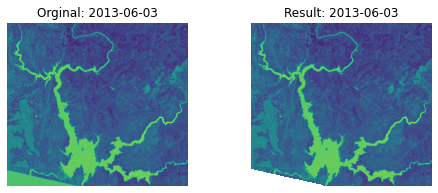

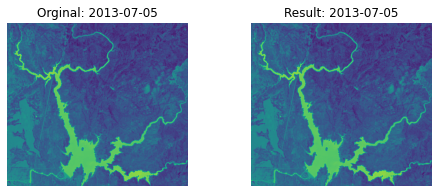

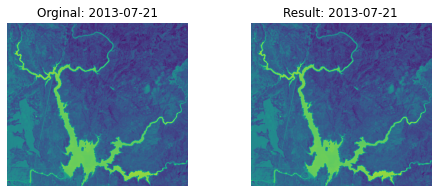

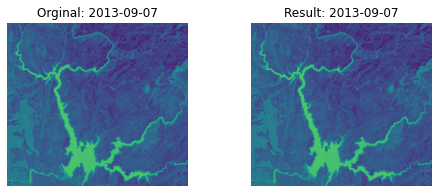

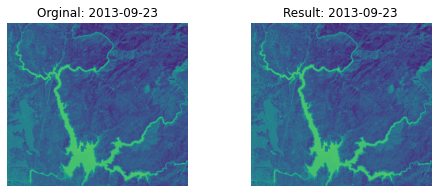

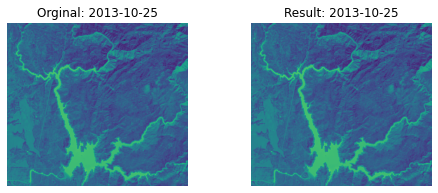

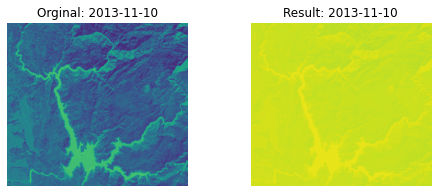

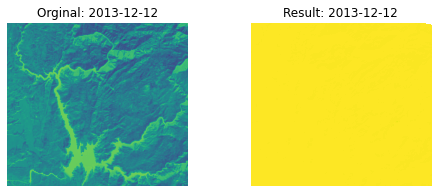

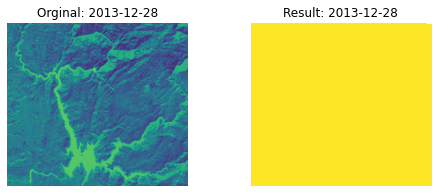

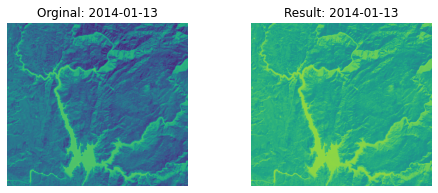

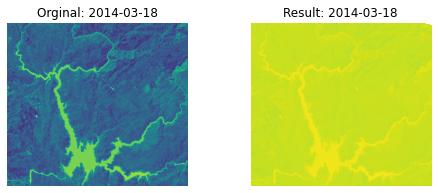

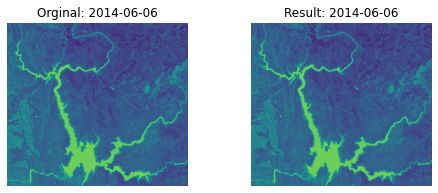

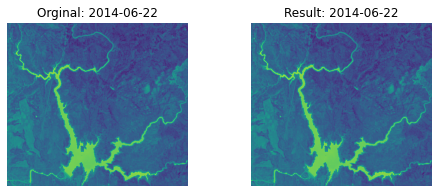

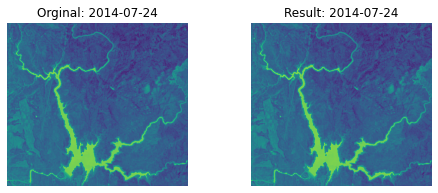

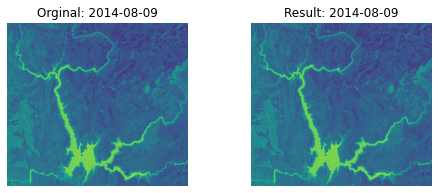

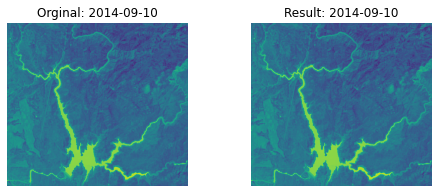

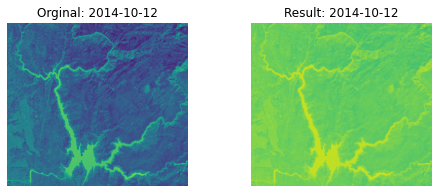

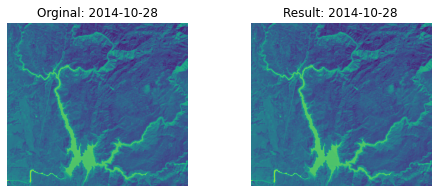

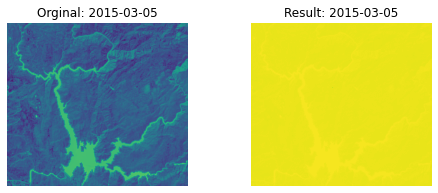

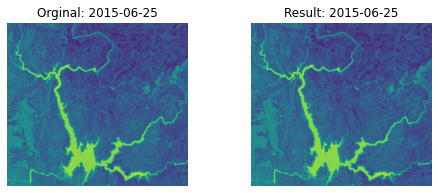

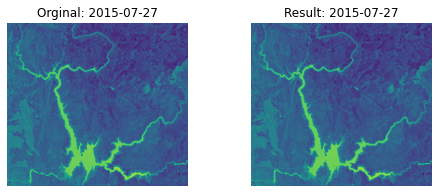

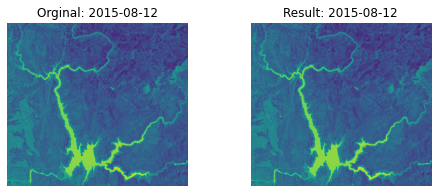

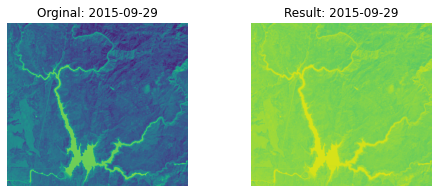

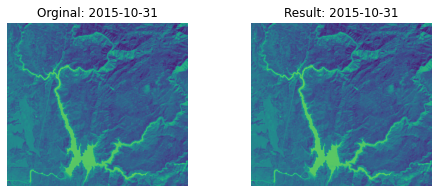

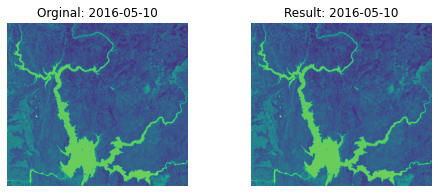

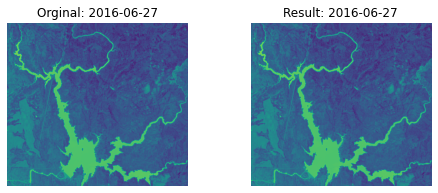

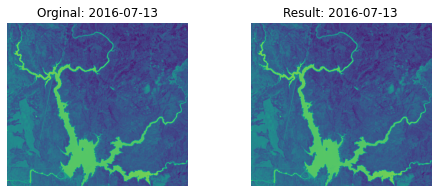

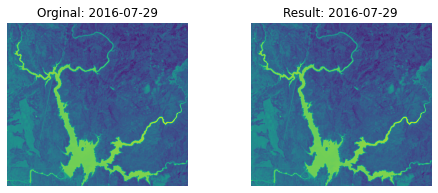

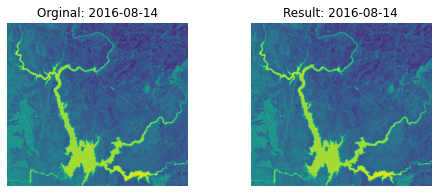

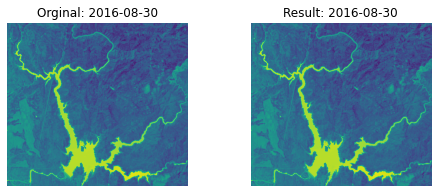

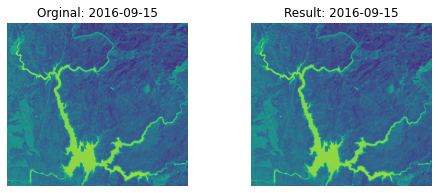

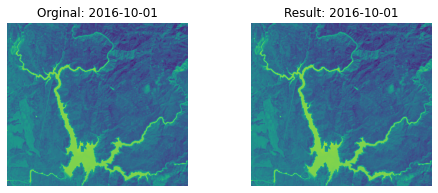

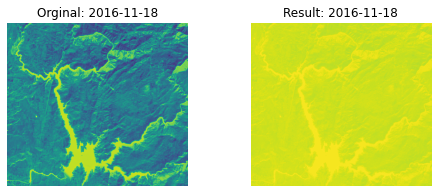

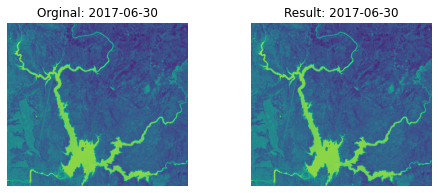

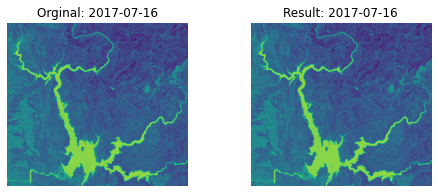

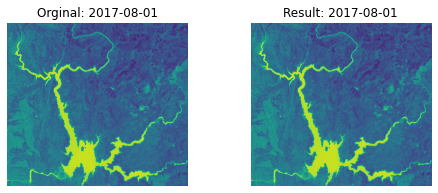

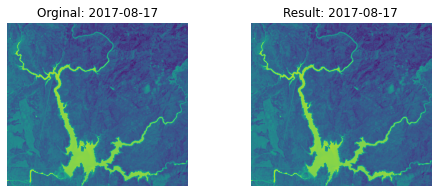

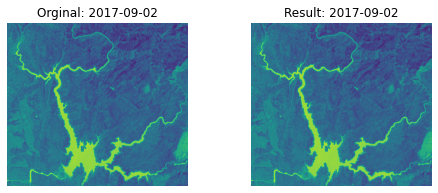

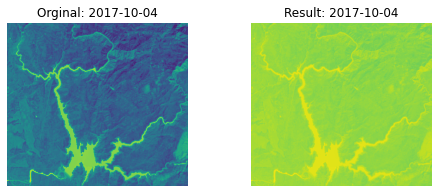

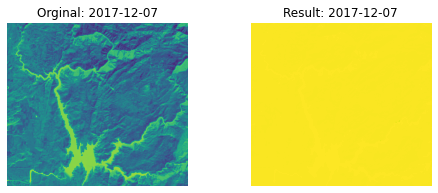

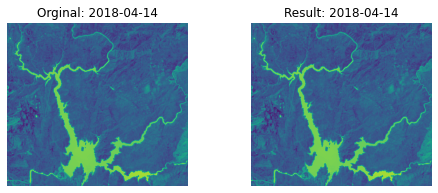

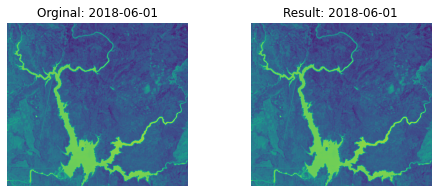

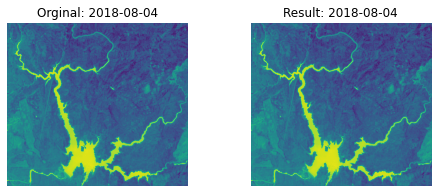

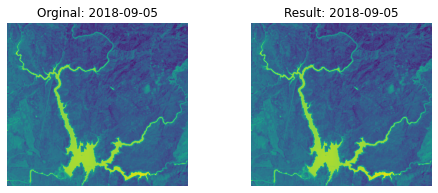

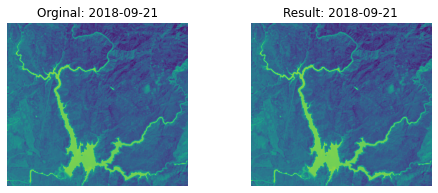

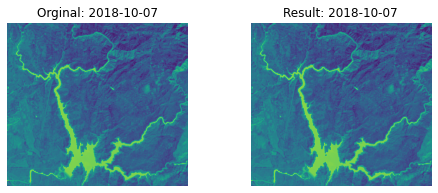

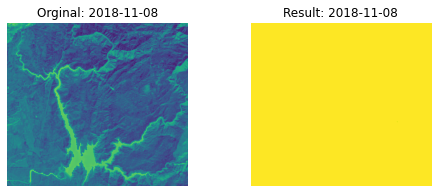

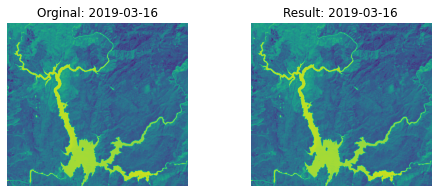

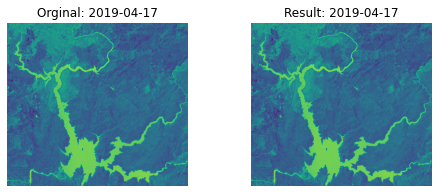

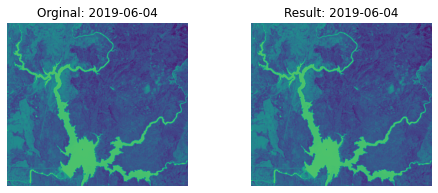

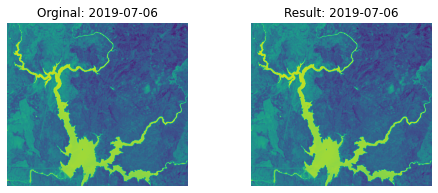

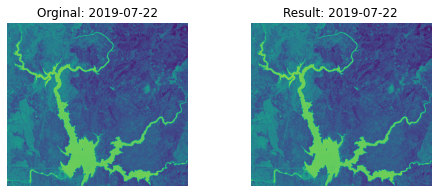

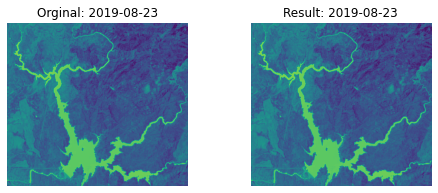

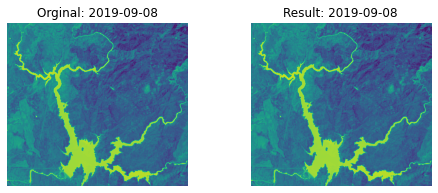

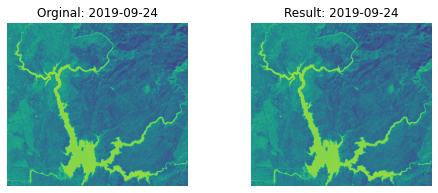

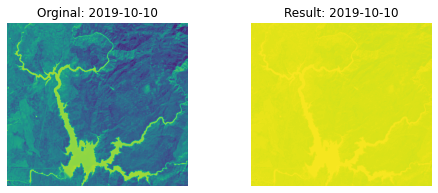

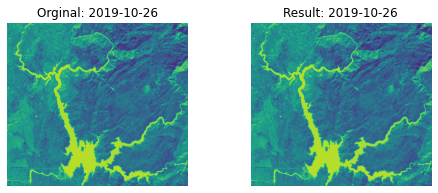

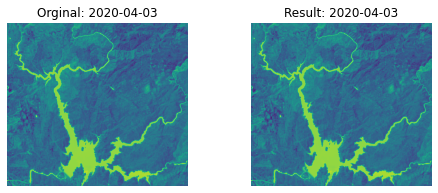

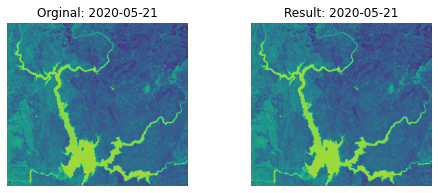

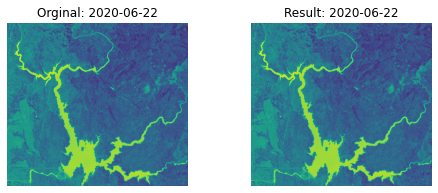

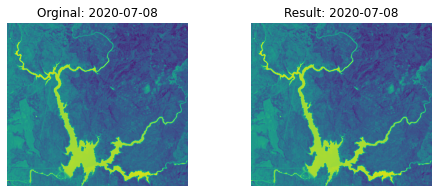

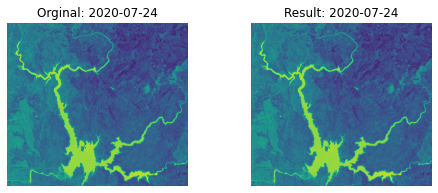

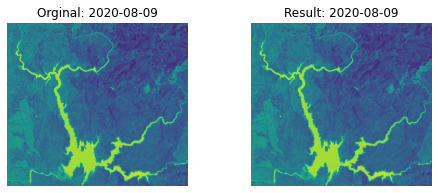

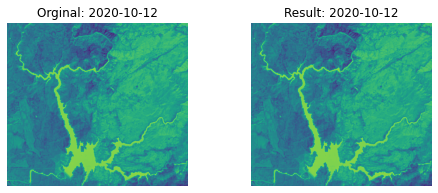

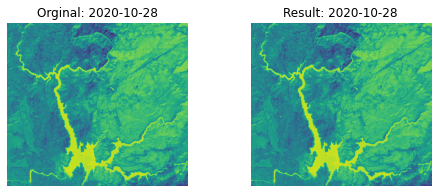

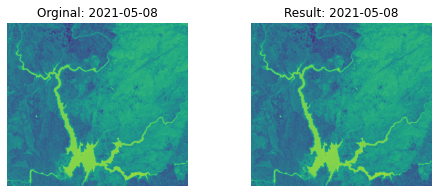

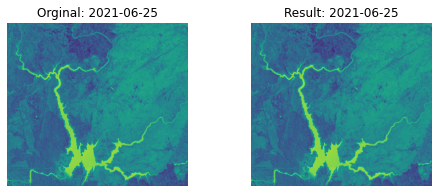

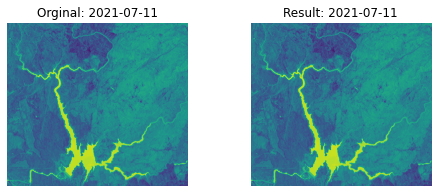

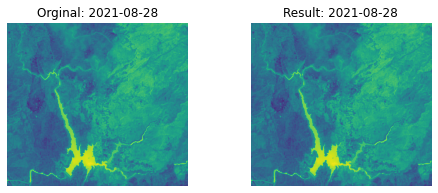

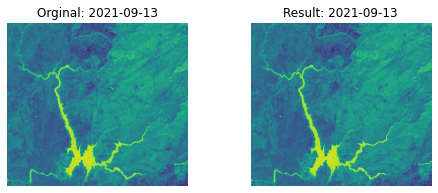

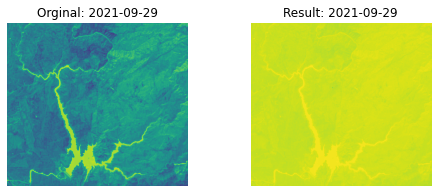

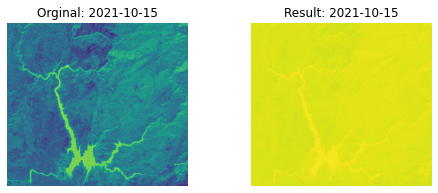

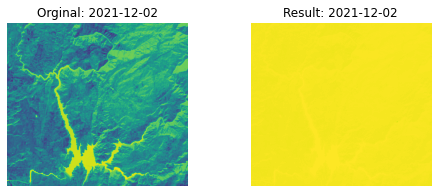

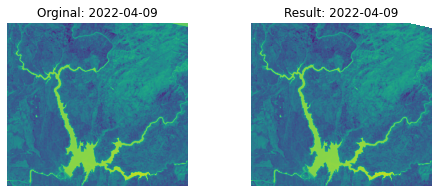

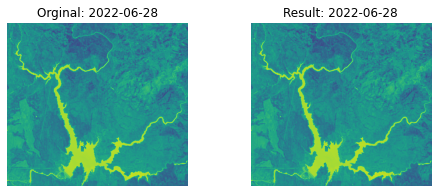

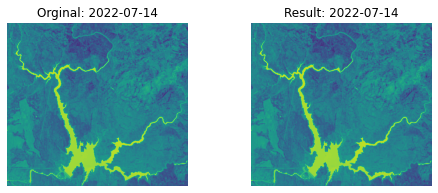

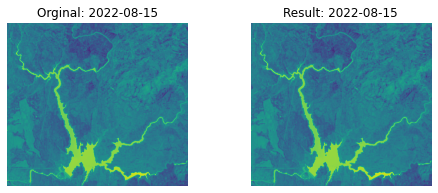

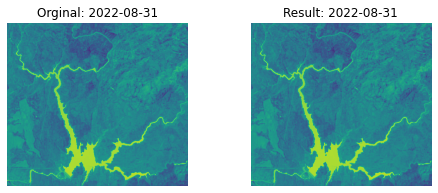

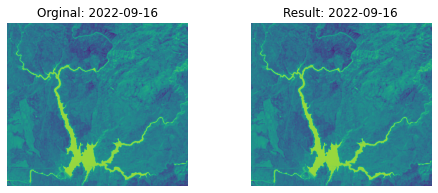

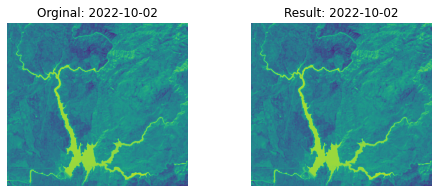

In [110]:
for n, c in zip(ndwi_img_lst, computed_ndwi_lst):
    
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    ax = axes.ravel()

    ax[0].imshow(n[1])
    ax[0].set_title('Orginal: {}'.format(n[0]))

    ax[1].imshow(c[1])
    ax[1].set_title('Result: {}'.format(c[0]))

    for a in ax:
        a.axis('off')

    plt.show()

In [ ]:
from skimage import data
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum

for d, i in ndwi_img_lst:
    thresh = threshold_minimum(i)
    binary = i > thresh

    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    ax = axes.ravel()

    ax[0].imshow(i, cmap=plt.cm.gray)
    ax[0].set_title('Orginal: {}'.format(d))

    ax[1].imshow(binary, cmap=plt.cm.gray)
    ax[1].set_title('Result: {}'.format(d))

    for a in ax:
        a.axis('off')

    plt.show()

### Using Folium to display an image from an ImageCollection

In [ ]:
# import a collection and convert to an image
image = ee.Image(ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA') 
                       .filterBounds(aoi) 
                       .filterDate(ee.Date('2020-08-01'), ee.Date('2020-08-31')) 
                       .first() 
                       .clip(aoi))

In [ ]:
# Create an NDWI image, define visualization parameters and display.
ndwi = image.normalizedDifference(['B3', 'B6'])
ndwi_viz = {'min': 0.4, 'max': 1, 'palette': ['blue', 'red']
}

In [ ]:
# Mask the non-watery parts of the image, where NDWI < 0.1.
ndwi_masked = ndwi.updateMask(ndwi.gte(0))

# Define a map centered on Lake Oroville.
map_ndwi_masked = folium.Map(location=[39.58, -121.47], zoom_start=11)

# Add the image layer to the map and display it.
map_ndwi_masked.add_ee_layer(image, {'min': .4, 'max': 1}, 'land mask')
map_ndwi_masked.add_ee_layer(ndwi_masked, ndwi_viz, 'NDWI masked')
display(map_ndwi_masked)

In [ ]:
image_rgb = image.visualize(**{'bands': ['B5', 'B4', 'B6'], 'max': 0.5})
ndwi_rgb = ndwi_masked.visualize(**{
    'min': 0.5,
    'max': 1,
    'palette': ['00FFFF', '0000FF']
})

In [ ]:
# Mosaic the visualization layers and display (or export).
mosaic = ee.ImageCollection([image_rgb, ndwi_rgb]).mosaic()

# Define a map centered on Lake Oroville.
map_mosaic = folium.Map(location=[39.58, -121.47], zoom_start=11)

# Add the image layer to the map and display it.
map_mosaic.add_ee_layer(mosaic, None, 'mosaic')
display(map_mosaic)